# Descripción del proyecto

Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos.

Se requiere predecir si un cliente dejará el banco pronto. contamos con los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.

Vamos a crear un modelo con el máximo valor F1 posible. se requiere un valor al menos de 0.59 y verificar el F1 para el conjunto de prueba.
Además se requerirá medir la métrica AUC-ROC y compararla con el valor F1


## Importando Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle


## Cargando dataset

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

## Explorando el contenido del dataset

In [3]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


In [5]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [6]:
data.shape

(10000, 14)

### **Conociendo el contenido de las columnas:**

* RowNumber - índice de fila en los datos
* CustomerId - identificador único del cliente
* Surname - apellido
* CreditScore - calificación crediticia
* Geography - país de residencia
* Gender - sexo
* Age - edad
* Tenure - período durante el cual ha madurado el depósito a plazo fijo de un cliente (años)cuántos años una persona ha sido cliente del banco
* Balance - saldo de la cuenta
* NumOfProducts - número de productos bancarios utilizados por el cliente
* HasCrCard - disponibilidad de tarjeta de crédito
* IsActiveMember - actividad del cliente
* EstimatedSalary - salario estimado

## Preprocesado de datos

### Normalizando nombres de columnas por convención (Snake case)

In [7]:
data.columns = data.columns.str.lower()

**Una vez normalizados los nombres de las columnas, vamos a analizarlas y decidir que realizar con ellas:**


* rownumber — indice de fila, no nos sirve para el modelo, se elimina.
* customerid — id de cliente, no nos sirve para el modelo, se elimina.
* surname —  apellido del cliente, no nos sirve para el modelo, se elimina.
* geography - columna categórica que indica el país del cliente, se realiza codificación One Hot
* gender —  Columna categórica que indica el género del cliente, se realiza codificación One Hot
* Tenure — se tienen datos faltantes que representan cerca del 9% del total, se rellena con la media de la columna.

Para las columnas:
* creditscore
* age
* tenure
* balance
* numofproducts
* estimatedsalary

**se realizará escalación de datos para estandarizar las escalas numéricas.**

Para las columnas:

* hascrcard 
* isactivemember 

**Ambas columnas son binarias (o booleanas) por lo tanto no vamos a realizar la estandarización sobre estas columnas.**


### **Trabajando con los datos ausentes en la columna 'tenure'**

Estos representan cerca del 9% de los datos totales, por este motivo vamos a rellenar los datos faltantes con la media de la columna

In [8]:
data['tenure'] = data['tenure'].fillna(data['tenure'].mean()) 


### Retirando las columnas que no son útiles para el modelo 
* rownumber
* customerid
* surname

In [9]:
data.drop(['rownumber','customerid','surname'], axis=1, inplace=True)

In [10]:
data.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


## Preparando datos para el modelo

### Realizando codificación One Hot para el dataframe

In [11]:
data = pd.get_dummies(data, drop_first=True)

In [12]:
data.head(3)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0


**De la codificación One Hot anteriormente realizada, podemos observar que se crearon las columnas:**
* geography_Germany
* geography_Spain
* gender_Male

### Segmentando datos en conjunto de entrenamiento, validación y prueba.

In [13]:
# Segmentando los conjuntos de datos (Entrenamiento ,validación y pruebas)
full_train_df, test_df = train_test_split(data, test_size=0.18, random_state=88)
train_df, valid_df  = train_test_split(full_train_df, test_size= .25 , random_state = 888)


In [14]:
#Verificando las porciones de la segmentación en relación al dataframe original (mega)
print([ len(df) for df in [data, full_train_df, train_df, valid_df, test_df]])

[round( len(df)/(len(data)) ,3 ) for df in [data, full_train_df, train_df, valid_df, test_df]]

[10000, 8200, 6150, 2050, 1800]


[1.0, 0.82, 0.615, 0.205, 0.18]

Decidimos que vamos a utilizar una segmentación de la siguiente manera:
* 82% de los datos para el conjunto completo de entrenamiento
* 61.5% de los datos para el conjunto de entrenamiento
* 20.5% de los datos para el conjunto de validación
* 18% de los datos para el conjunto de prueba

### Definiendo los Objetivos y Características (Features y Target)

In [15]:
#Definiendo los features y target
target = 'exited'
features = [i for i in data.columns if i not in [target]]
# probar solamente "dropping" exitedd features = [i for i in data.columns if i not in [target]]

print(target)
print(features)


exited
['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary', 'geography_Germany', 'geography_Spain', 'gender_Male']


### Comprobando el desequilibrio de clases

In [16]:
#Calculando el promedio del target
print(f'La cantidad promedio de usuarios que se han ido de Beta bank es del: {round(data[target].mean()*100,2)}% del total ', )
print(f'La cantidad promedio de usuarios que han permanecido en Beta bank es del: {round((1-data[target].mean())*100,2)}% del total ', )

La cantidad promedio de usuarios que se han ido de Beta bank es del: 20.37% del total 
La cantidad promedio de usuarios que han permanecido en Beta bank es del: 79.63% del total 


Con los datos anteriores **podemos observar un claro desequilibrio de clases**, esto lo determinamos cuando la probabilidad de que la variable (columna) 'exited' sea 1 está muy lejana al 50%, que en este caso observamos un 20% de probabilidad de que el usuario haya desertado contra un casi 80% de que el usuario no haya desertado.

### Explorando visualmente los datos de las columnas características (features)

In [17]:
# for feature in features:
#     plt.figure(figsize=(8,4))
#     data.query("exited == 0")[feature].hist(label='no', alpha=0.25, ax=plt.gca(), density = True)
#     data.query("exited == 1")[feature].hist(label='yes', alpha=0.25, ax=plt.gca(), density = True)
#     plt.legend(title='exited')
#     plt.xlabel(feature)
#     plt.show()

En esta primera exploración podemos observar:
* Los usuarios con un credit score entre 650 y 730 son los que menos suelen irse del banco
    * Esto puede deberse a que tienen mejor conocimiento financiero y crediticio
    
    
* Los usuarios más jóvenes (entre los 20 y 40 años) son los que menos suelen irse del banco, en cambio los usuarios de 40+ años, tienen una tasa más alta de deserción.
 
    * Esto puede deberse a que los usuarios jóvenes no suelen tener puntajes crediticios altos, y se quedan con una institución que les abrió las puertas como primera oportunidad, al menos hasta que construyen un mejor credit score


* No se observan tendencias importantes en la tenencia de los usuarios (Tenure)


* Los usuarios con un balance mayor a 100000 dls suelen irse del banco.
    * Esto puede deberse a que encuentran mejores opciones donde tener su dinero
    
    
* Aunque es obvio, los usuarios que tienen actividad, suelen quedarse y los que no, suelen irse del banco.


* Los usuarios con salarios mayores a 150000 dls suelen tener un índice de deserción más alto que los salarios inferiores, aunque no generan una tendencia muy importante.


* Los usuarios Alemanes suelen tener un indice de deserción alto


* Los usuarios Españoles tienen mayor lealtad a los usuarios Alemanes y suelen permancere en el banco


* Las mujeres tienen un índice de deserción más alto que el de los hombres.



### Escalando datos

In [18]:
data.columns

Index(['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited', 'geography_Germany',
       'geography_Spain', 'gender_Male'],
      dtype='object')

In [165]:
#Definiendo columnas numéricas (a escalar)
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']

#Creando la instancia de StandardScaler
scaler = StandardScaler()

#Entrenando el escalador con los datos de entrenamiento (full_train)
scaler.fit(full_train_df[numeric])

#Escalando los datos de entrenamiento, prueba y validación
train_df_scaled = train_df.copy()
train_df_scaled[numeric]= scaler.transform(train_df_scaled[numeric])

valid_df_scaled = valid_df.copy()
valid_df_scaled[numeric]= scaler.transform(valid_df_scaled[numeric])

test_df_scaled = test_df.copy()
test_df_scaled[numeric] = scaler.transform(test_df_scaled[numeric])


## Probando el modelo de regresión logística sin tener en cuenta el desequilibrio de clases

In [20]:
#Creando instancia del modelo
lr_model_raw= LogisticRegression()

#Entrenando el modelo con los datos de entrenamiento *sin escalar*
lr_model_raw.fit(full_train_df[features],full_train_df[target])

# Evaluando el modelo sin tener en cuenta el desequilibrio
lr_predictions_valid = lr_model_raw.predict(test_df[features])

# Calculando el f1 score
lr_f1_score= f1_score(test_df[target],lr_predictions_valid)
print("F1 Score con datos sin modificar hiperparámetros y sin tomar en cuenta el desequilibrio: ",round(lr_f1_score,4))


F1 Score con datos sin modificar hiperparámetros y sin tomar en cuenta el desequilibrio:  0.0892


Podemos observar que sin tomar en cuenta el desequilibrio de clases y sin modificar ningún hiperparámetro, el F1 score nos arroja un valor de 0.0892, el cual está muy alejado del valor deseado 0.59.

Veamos cual es el ROC-AUC score para el model sin mejorar sus hiperparámetros

In [21]:
lr_predictions_valid_one = lr_model_raw.predict_proba(test_df[features])[:,1]

print("El valor ROC-AUC para el modelo que no toma en cuenta el desequilibrio de clases es: ", round(roc_auc_score(test_df[target],lr_predictions_valid_one),4))


El valor ROC-AUC para el modelo que no toma en cuenta el desequilibrio de clases es:  0.6625


Podemos observar que el valor ROC-AUC es de 0.66, el cual está peligrosamente cerca del valor 0.5, que es el valor ROC-AUC cuando el modelo predice de manera aleatoria lo cual sería un modelo que no funciona.

En conclusión, nuestro modelo no es lo suficientemente bueno para salir a producción, por lo tanto vamos a probar algunos ajustes de hiperparámetros y estrategias para manejar el desequilibrio de clases

## Probando el modelo de regresión logística tomando en cuenta el desequilibrio de clases

### Buscando el mejor Umbral y Peso de Clase para el conjunto de validación

In [22]:
#Buscando el mejor umbral para la regresión logística

class_weights = [4, 4.5, 5, 5.5, 6]
best_final_class_weight = 0
best_final_score = -1
best_final_threshod = -1

for class_weight in class_weights :
    #Creando instancia del modelo
    lr_model = LogisticRegression()

    #Entrenando el modelo con los datos de entrenamiento
    lr_model.fit(train_df_scaled[features],train_df_scaled[target] )

    #Generando predicciones de la clase "1" con los datos de validación
    predictions_valid_lr = lr_model.predict_proba(valid_df_scaled[features])[:,1] 
    
    thresholds=[]
    f1_scores = []
    best_threshold = -1
    best_f1_score = -1




    for t in np.linspace(0, 0.4, 21):
            #si la predicción supera al umbral establecido, lo guardamos en un vector
            predictions_valid_lr_class = predictions_valid_lr > t
    
            #realizamos append al umbral iterado a la lista de umbrales
            thresholds.append(t)
            
            # calculamos el f1 score con las predicciones de clase y el target del conjunto de validación
            f1_score_result = f1_score(valid_df[target],predictions_valid_lr_class)
    
            #realizamos append al f1 score obtenido en la iteración a la lista de f1 scores
            f1_scores.append(f1_score_result)
    
            #evaluamos si el f1 score fue mejor al best score previo
            if f1_score_result > best_f1_score:
                #hacemos reemplazo de valores en las variables best f1 score y best threshold
                best_f1_score= f1_score_result
                best_threshold = t
        
            # creamos un dataframe a partir de dos listas (columnas): thresholds y f1_scores
            evaluations = pd.DataFrame(data={
            "threshold": thresholds,
            "f1_score": f1_scores
            })
    #Evaluamos si el mejor f1 score es mejor al mejor f1 score previo            
    if best_f1_score > best_final_score:
            #hacemos reemplazo de valores en las variables best final score, best final threshold y best final class weight
            best_final_score = best_f1_score
            best_final_threshold = best_threshold
            best_final_class_weight = class_weight

In [23]:
print(f"Mejor score: {best_final_score}, mejor peso de clase: {best_final_class_weight}, mejor umbral: {best_final_threshod} ")

Mejor score: 0.5093411996066863, mejor peso de clase: 4, mejor umbral: -1 


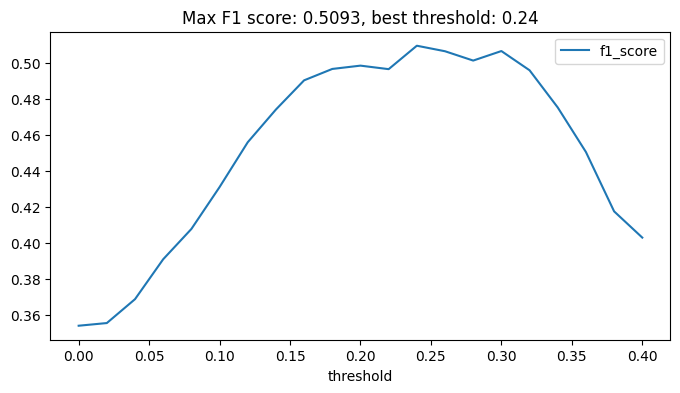

In [24]:
#Graficamos el dataframe creado a partir de los f1 score y los umbrales
plt.figure(figsize=(8,4))
plt.title(f'Max F1 score: {round(best_f1_score,4)}, best threshold: {best_threshold}')
evaluations.plot(kind='line', x='threshold',y='f1_score', ax = plt.gca())
plt.show()

Podemos observar que el mejor desempeño del F1 Score para el modelo de Regresión Logística con el dataset de entrenamiento fue con un umbral de 0.24 y un peso de clase igual a 4, con estos hiperparámetros obtuvimos un desempeño del F1 Score de 0.5093, el cual aún no es suficiente para el desempeño que deseamos de al menos 0.59.

Veamos como se comporta en el dataset de validación

### Probando los hiperparámetros en el conjunto de prueba

In [164]:
#Escalando los datos de entrenamiento completos
full_train_df_scaled = full_train_df.copy()
full_train_df_scaled[numeric] = scaler.transform(full_train_df_scaled[numeric])

final_lr_model = LogisticRegression(class_weight={0:1, 1:best_final_class_weight})

final_lr_model.fit(full_train_df_scaled[features],full_train_df_scaled[target])

test_predictions = final_lr_model.predict_proba(test_df_scaled[features])[:,1]


class_test_predictions= test_predictions > best_final_threshold

final_f1_score_result = f1_score(test_df[target],class_test_predictions)

print(final_f1_score_result)

0.3900789177001127


### Hallazgos del modelo de regresión logística
Podemos observar que:

**Sin considerar el desequilibrio de clases**
* El modelo sin entrenar presentó un F1 score de 0.089 el cual está muy alejado del valor deseado (0.59)
* El modelo sin entrenar presentó un ROC-AUC de 0.6625 el cual no está lo suficientemente separado del 0.5 (hacia la unidad 1) para considerar que el modelo es bueno realizando predicciones de clase "1".

**Considerando el desequilibrio de clases**
* El modelo presentó un mejor desempeño con el conjunto de entrenamiento que con el de prueba
* El mejor desempeño del modelo con el conjunto de entrenamiento arrojó un F1 score de: 0.5093
* El desempeño del modelo con el conjunto de prueba y con los mejores hiperparámetros arrojó un F1 score de: 0.390

Vamos a probar algunas otras estrategias para mejorar el F1 score, entre ellas:
* **Ajuste de peso de clase balanceado**
    * Este hiperparámetro funciona de manera similar al submuestreo y sobremuestreo, asigna un peso de clases balanceado para favorecer a la clase minoritaria y acercarla al peso de clase de la clase mayoritaria, buscando la relación 1:1
* **Submuestreo**
    * Esta técnica nos ayuda a seleccionar una fracción de los datos de la clase mayoritaria para tratar de equilibrar los pesos de clase comparado a la clase minoritaria, buscando una relación 1:1.
* **Grid Search CV (Búsqueda de cuadrícula)**
    * Es una técnica de búsqueda exhaustiva que encuentra la combinación óptima de hiperparámetros para un módelo.



### Probando ajustes de hiperparámetro peso de clase balanceado

In [26]:
## probando

#Escalando los datos de entrenamiento completos
full_train_df_scaled = full_train_df.copy()
full_train_df_scaled[numeric] = scaler.transform(full_train_df_scaled[numeric])

final_lr_model = LogisticRegression(class_weight='balanced')

final_lr_model.fit(full_train_df_scaled[features],full_train_df_scaled[target])
test_predictions = final_lr_model.predict_proba(test_df_scaled[features])[:,1]


class_test_predictions= test_predictions > best_final_threshold

final_f1_score_result = f1_score(test_df[target],class_test_predictions)
ac= accuracy_score(test_df[target],class_test_predictions)
print(final_f1_score_result)


0.3931818181818182


**Podemos observar que el f1 score mejoró pasando de 0.39 a 0.393, sigamos explorando estrategias**

### Probando submuestreo para mejorar el desequilibrio de clase

In [129]:
#Verificando que relación de clase tiene el valor 1 contra el valor 0
full_train_df[target].value_counts(normalize=True)

0    0.79622
1    0.20378
Name: exited, dtype: float64

**Obtenemos una relación prácticamente 4 a 1 entre las clases 0 y 1 , vamos a hacer submuestreo de la clase dominante 0**

In [131]:
#Definiendo los features y target para el conjunto full_train_df
# features_full1=full_train_df_scaled[numeric]
features_full=full_train_df[features]
target_full = full_train_df[target]

#Separando el conjunto de entrenamiento en observaciones negativas y positivas

feautres_zeros = features_full[target_full==0]
feautres_ones = features_full[target_full==1]
target_zeros = target_full[target_full==0]
target_ones = target_full[target_full==1]

#Fraccionando las observaciones y uniéndolas en un nuevo conjunto de features 
features_downsampled = pd.concat( [feautres_ones] + [feautres_zeros.sample(frac=0.25, random_state=12345)])
target_downsampled = pd.concat( [target_ones] + [target_zeros.sample(frac=0.25, random_state=12345)])

#Mezclamos los valores obtenidos
features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)

model_downsampled = LogisticRegression(solver='liblinear', random_state=12345)
model_downsampled.fit(features_downsampled,target_downsampled)

downsampled_predictions = model_downsampled.predict(test_df[features])


f1_downsamp = f1_score(test_df[target] ,downsampled_predictions)
print(f1_downsamp)

0.4498207885304659


In [29]:
#Comparando nuevamente el equlibrio de clase
full_train_down = features_downsampled.copy()
full_train_down['exited'] = target_downsampled


full_train_down[target].value_counts(normalize=True)

1    0.505904
0    0.494096
Name: exited, dtype: float64

**Podemos observar que la relación de clase es prácticamente 1:1 por lo tanto está equilibrada**

**Podemos observar que el f1 score mejoró notablemente pasando de 0.3931 a 0.449, sigamos explorando estrategias para verificar si podemos mejorar nuestro score**

### Probando GridSearch para encontrar los mejores hiperparámetros del modelo

#### Probando GridSearch sin submuestreo

In [136]:
#Probando GridSearch para encontrar los mejores hiperparámetros del modelo
final_lr_model_Grid= LogisticRegression(solver='liblinear', random_state=42)

# Definimos la cuadrícula de hiperparámetros que deseamos ajustar
param_grid = {
    'C': [0.1, 1.0, 10.0],  
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 200, 300],
    'class_weight': [None, 'balanced'],
    'random_state': [42]
}

#Creamos la instancia GridSearch y la entrenamos con el conjunto entero de entrenamiento sin submuestreo
grid_search = GridSearchCV(estimator=final_lr_model_Grid, param_grid = param_grid , cv = 5, scoring = 'f1')
grid_search.fit(full_train_df[features],full_train_df[target])


# Mostramos los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)


# Evaluamos el modelo en el conjunto de prueba mediante el f1 score
f1_grid = grid_search.score(test_df[features], test_df[target])
print("F1 score en el conjunto de prueba:", f1_grid)



Mejores hiperparámetros: {'C': 1.0, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'random_state': 42}
F1 score en el conjunto de prueba: 0.4942528735632184


**Podemos observar que  entrenando el Grid search sin submuestreo y utilizando los hiperparámetros que la herramienta Grid search nos recomienda, nos arroja un f1 score de 0.494, veamos como se comporta con submuestreo.**

#### Probando GridSearch con submuestreo

In [33]:
#Probando GridSearch para encontrar los mejores hiperparámetros del modelo
final_lr_model_Grid= LogisticRegression(solver='liblinear', random_state=42)

# Definimos la cuadrícula de hiperparámetros que deseamos ajustar
param_grid = {
    'C': [0.1, 1.0, 10.0],  
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 200, 300],
    'class_weight': [None, 'balanced'],
    'random_state': [42]
}

# creamos la instancia GridSearch y la entrenamos con los datos aplicado el submuestreo
grid_search = GridSearchCV(estimator=final_lr_model_Grid, param_grid = param_grid , cv = 5 , scoring = 'f1')
grid_search.fit(features_downsampled,target_downsampled)


# Mostramos los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

# Evaluamos el modelo en el conjunto de prueba mediante el f1 score
f1_grid2 = grid_search.score(test_df[features], test_df[target])
print("Precisión en el conjunto de prueba:", f1_grid2)


Mejores hiperparámetros: {'C': 0.1, 'class_weight': None, 'max_iter': 100, 'penalty': 'l1', 'random_state': 42}
Precisión en el conjunto de prueba: 0.4794776119402984


**Podemos observar que  entrenando el Grid search con submuestreo y utilizando los hiperparámetros que la herramienta Grid search nos recomienda, nos arroja un f1 score de 0.479, ligeramente inferior al 0.494 arrojado cuando se entrena sin submuestreo, vamos a probar los diferentes hiperparámetros con el conjunto de datos de prueba y el modelo de regresión logística.**

### Probando el modelo con los mejores hiperparámetros,  escaldo de características y submuestreo de datos.

#### Probando con class_weight ='balanced', conjuntos de datos escalados y sin submuestreo:

In [159]:
# features_downsampled,target_downsampled

#Escalando los datos de entrenamiento completos
# full_train_df_scaled = full_train_df.copy()
# full_train_df_scaled[numeric] = scaler.transform(full_train_df_scaled[numeric])

final_lr_model_balanced = LogisticRegression(class_weight= 'balanced', C=1.0, max_iter=100, penalty='l1', random_state=42, solver='liblinear')


final_lr_model_balanced.fit(full_train_df_scaled[features],full_train_df_scaled[target])


test_predictions_bal = final_lr_model_balanced.predict(test_df_scaled[features])


final_f1_score_result_bal = f1_score(test_df[target],test_predictions_bal)

print(final_f1_score_result_bal)

0.49377990430622


#### Probando con class_weight ='balanced', conjuntos de datos escalados y con submuestreo:

In [163]:
# features_downsampled,target_downsampled

final_lr_model_balanced_sub = LogisticRegression(class_weight= 'balanced', C=1.0, max_iter=100, random_state=42, solver='liblinear')

final_lr_model_balanced_sub.fit(features_downsampled,target_downsampled)

test_predictions_bal_sub = final_lr_model_balanced_sub.predict(test_df_scaled[features])


final_f1_score_result_bal_sub = f1_score(test_df[target],test_predictions_bal_sub)

print(final_f1_score_result_bal_sub)

0.4978540772532189


#### Probando con class_weight = None, conjuntos de datos escalados y con submuestreo

In [170]:

final_lr_model = LogisticRegression(class_weight= None, C=1.0, max_iter=100,  random_state=42, solver='liblinear')
# final_lr_model = LogisticRegression(class_weight= 'balanced', C=1.0, max_iter=100,  random_state=42, solver='liblinear')


final_lr_model.fit(features_downsampled,target_downsampled)
# final_lr_model.fit(full_train_df_scaled[features],full_train_df_scaled[target])


test_predictions = final_lr_model.predict(test_df_scaled[features])


final_f1_score_result_none = f1_score(test_df[target],test_predictions)

print(final_f1_score_result_none)

0.45494830132939446


#### Probando con class_weight = None, conjuntos de datos escalados y sin submuestreo

In [189]:

final_lr_model = LogisticRegression(class_weight= None, penalty='l2', C=1.0, max_iter=100,  random_state=42, solver='liblinear')

final_lr_model.fit(full_train_df_scaled[features],full_train_df_scaled[target])


test_predictions = final_lr_model.predict(test_df_scaled[features])


final_f1_score_result_none = f1_score(test_df[target],test_predictions)

print(final_f1_score_result_none)

0.3300589390962672


#### Probando con datos escalados, class weight None , mejor umbral (0.24) y sin submuestreo

In [183]:

final_lr_model_thres = LogisticRegression(class_weight= None, C=1.0, max_iter=100, penalty='l1', random_state=42, solver='liblinear')


final_lr_model_thres.fit(full_train_df_scaled[features],full_train_df_scaled[target])

test_predictions = final_lr_model_thres.predict_proba(test_df_scaled[features])[:,1]

class_test_predictions= test_predictions > best_final_threshold

final_f1_score_result_thres = f1_score(test_df[target],class_test_predictions)

print(final_f1_score_result_thres)

0.48936170212765956


#### Probando con datos escalados, class weight None , mejor umbral (0.24) y con submuestreo

In [188]:
final_lr_model_thres2 = LogisticRegression(class_weight= None, penalty='l2', C=1.0, max_iter=100, random_state=42, solver='liblinear')

final_lr_model_thres2.fit(features_downsampled,target_downsampled)


test_predictions = final_lr_model_thres2.predict_proba(test_df_scaled[features])[:,1]

class_test_predictions= test_predictions > best_final_threshold

final_f1_score_result_thres2 = f1_score(test_df[target],class_test_predictions)

print(final_f1_score_result_thres2)

0.3379501385041551


## Conclusiones del modelo de regresión logística
Podemos observar que:

**Sin considerar el desequilibrio de clases**
* El modelo sin entrenar presentó un F1 score de 0.089 el cual está muy alejado del valor deseado (0.59)
* El modelo sin entrenar presentó un ROC-AUC de 0.6625 el cual no está lo suficientemente separado del 0.5 (hacia la unidad 1) para considerar que el modelo es bueno realizando predicciones de clase "1".

**Considerando el desequilibrio de clases**
* El modelo presentó un mejor desempeño con el conjunto de entrenamiento que con el de prueba
* El mejor desempeño del modelo con el conjunto de entrenamiento arrojó un F1 score de: 0.5093
* El desempeño del modelo con el conjunto de prueba y con los mejores hiperparámetros arrojó un F1 score de: 0.390

**Habiendo probado las siguientes estrategias para mitigar el desequilibrio de clases:**
* **Ajuste de peso de clase balanceado**
* **Submuestreo**
* **Grid Search CV (Búsqueda de cuadrícula)**
    

**Pudimos llegar a la siguiente conclusión:**

Configurando el modelo con class_weight ='balanced', utilizando el conjuntos de datos escalados y utilizando el submuestreo logramos un F1 score = 0.4978 el cual se vio notoriamente mejorado en comparación al obtenido sin las herramientas de peso de clase y Grid Search CV que nos arrojó en la iteración previa un F1 score = 0.390 .


logramos mejorar de manera muy notoria el desempeño del modelo de regresión logística, ahora vamos a explorar con un modelo de bosque aleatorio para comparar su desempeño

## Probando modelo de clasificador de bosque aleatorio (Random Forest Classifier)

### Probando el clasificador con el mejor peso de clase y con n_estimators = 150

In [ ]:
class_weights = {0: 1, 1: best_final_class_weight} 

rf_model = RandomForestClassifier(random_state=123456,class_weight= class_weights, n_estimators=150)
rf_model.fit(full_train_df[features],full_train_df[target])

rf_predictions=rf_model.predict(test_df[features])

fr_f1_score = f1_score(test_df[target],rf_predictions)

print(fr_f1_score)

Podemos observar que el modelo incremento notablemente su desempeño, arrojando un F1 score de 0.560, sin embargo aún no cumple con el F1 score necesario mayor a 0.59, por lo tanto vamos a realizar un ajuste de umbrales y verificar su desempeño

### Probando el clasificador con el mejor peso de clase,  n_estimators = 150 y ajuste de umbral a 0.3

In [ ]:
class_weights = {0: 1, 1: best_final_class_weight} 

rf_model = RandomForestClassifier(random_state=123456,class_weight= 'class_weights')
rf_model.fit(full_train_df[features],full_train_df[target])


rf_proba_one = rf_model.predict_proba(test_df[features])[:,1]

threshold=0.3

predicted_test = rf_proba_one > threshold

fr_f1_score = f1_score(test_df[target],predicted_test)

print(fr_f1_score)

Podemos observar que:

**El F1 score ha rebasado el valor mínimo para el planteamiento de este problema con un F1 score = 0.608 > 0.59.**

vamos a compararlo con el valor AUC-ROC


In [ ]:
auc_roc= roc_auc_score(test_df[target],rf_proba_one )
print(auc_roc)

Podemos observar que:

**El ROC-AUC score es de 0.85 lo cual es un score positivo considerando que entre más cercano se encuentre a 1 nuestro modelo será más hábil a la hora de clasificar correctamente los valores positivos.**


## Conclusiones

Podemos observar que:

* El modelo de regresión logística, sin el procesado de datos y la manipulación de hiperparámetros presenta un desempeño del F1 score muy pobre, apenas del 0.089 y un ROC-AUC de 0.66, el cual está muy cercano al valor 0.5 que significa que el modelo tiene un rendimiento aleatorio.


* El modelo de bosque aleatorio de clasificación se comporta mucho mejor que el modelo de regresión logística, arrojándonos un primer valor F1 score = 0.56, una vez mejorando los hiperparámetros (umbral, peso de clase y n_estimators) logramos un F1 score =0.608 el cual supera el valor deseado de 0.59, también nos presenta un ROC-AUC = 0.85 el cual indica que el modelo es capaz de clasificar correctamente el 85% de las instancias positivas, lo cual es muy deseable.


En conclusión, pudimos verificar que el ajuste de hiperparámetros, la codificación y el estandarizado de los datos nos aporta mucho valor a la hora de entrenar un modelo clasificatorio, también pudimos verificar que los bosques aleatorios tienen un mejor rendimiento que el modelo de regresión logística.

Con todos los ajustes que realizamos **logramos entrenar un modelo capaz de clasificar correctamente el 85% de las instancias positivas.**

